<a href="https://colab.research.google.com/github/yeowonh/2021_summer/blob/main/Tokyo_olympic_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020 Tokyo Olympic - Topic & visualization

# 라이브러리 및 데이터

In [ ]:
# 드라이브 마운트
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# 데이터 불러오기
tweets_2020 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/tokyo_2020_tweets.csv") # keyword, 감정분석용

# 2021 Olympics in Tokyo
athletes_2020 = pd.read_excel("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/tokyo_2020_Athletes.xlsx", sheet_name='Details')
coaches_2020 = pd.read_excel("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/tokyo_2020_Coaches.xlsx", sheet_name='Details')
teams_2020 = pd.read_excel("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/tokyo_2020_Teams.xlsx", sheet_name='Details')
gender_2020 = pd.read_excel("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/tokyo_2020_EntriesGender.xlsx", sheet_name='Details')

# olympic Games Hosts
noc_region_total = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/olympic_noc_regions.csv")
host_total = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/olympic_hosts.csv")

# Olympic Games Medals, 1986-2018
meta_host_total = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/olympic_metadata_host.csv")
medals_total = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/olympic_medals.csv")

# 원본 데이터 불러올 시 parsererror 발생. column 9 delete 후 불러와야 함
# Olympic Track & Field Results
field_total = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/olympic_field_athletes.csv")
# Olympics Athlete Events Analysis
event_total = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Olympic/data/olympic_athlete_events.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,5,6,7,8,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## tweets wordcloud

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 43.2 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
tweets_2020.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1418888645105356803,Abhishek Srivastav,"Udupi, India",Trying to be mediocre in many things,2021-02-01 06:33:51,45,39,293,False,2021-07-24 10:59:49,Let the party begin\n#Tokyo2020,['Tokyo2020'],Twitter for Android,0.0,0.0,False
1,1418888377680678918,Saikhom Mirabai Channu🇮🇳,"Manipur, India",Indian weightlifter 48 kg category. Champion🏆,2018-04-07 10:10:22,5235,5,2969,False,2021-07-24 10:58:45,Congratulations #Tokyo2020 https://t.co/8OFKMs...,['Tokyo2020'],Twitter for Android,0.0,0.0,False
2,1418888260886073345,Big Breaking,Global,All breaking news related to Financial Market....,2021-05-29 08:51:25,3646,3,5,False,2021-07-24 10:58:17,Big Breaking Now \n\nTokyo Olympic Update \n\n...,NaN,Twitter for Android,0.0,1.0,False
3,1418888172864299008,International Hockey Federation,Lausanne,Official International Hockey Federation Twitt...,2010-10-20 10:45:59,103975,2724,36554,True,2021-07-24 10:57:56,Q4: 🇬🇧3-1🇿🇦\n\nGreat Britain finally find a wa...,NaN,Twitter Web App,1.0,0.0,False
4,1418886894478270464,Cameron Hart,Australia,Football & Tennis Coach,2020-10-31 08:46:17,6,37,31,False,2021-07-24 10:52:51,All I can think of every time I watch the ring...,"['Tokyo2020', 'ArtisticGymnastics', '7Olympics...",Twitter for iPhone,0.0,0.0,False


In [ ]:
tweets_2020['text'] = tweets_2020['text'].apply(str)

In [ ]:
text_list = tweets_2020['text'].apply(lambda x : x.replace('\\n', '').replace('#Tokyo2020', '').replace('https://t.co/', '').replace('\\nName: text', '').replace('dtype: object', '').replace('Length: ', ''))

In [ ]:
BoW = []
from tensorflow.keras.preprocessing.text import text_to_word_sequence
for text in text_list:
  for word in text_to_word_sequence(text):
    BoW.append(word)

print(len(BoW), BoW[:5])

531388 ['let', 'the', 'party', 'begin', 'congratulations']


In [ ]:
BoW_series = pd.Series(BoW)
BoW_series

0                     let
1                     the
2                   party
3                   begin
4         congratulations
               ...       
531383               gold
531384    congratulations
531385              priya
531386                  …
531387         moedsl8cuy
Length: 531388, dtype: object

In [ ]:
tweets_hashtag = tweets_2020[tweets_2020['hashtags'].notnull()]['hashtags'].reset_index(drop=True)
tweets_hashtag = tweets_hashtag.apply(lambda x : x.replace('[', '').replace(']', '').replace('\'', '').replace(' ', ''))
hashtag_list = []
for hashtag in tweets_hashtag:
  word_list = hashtag.split(',')
  for word in word_list:
    hashtag_list.append(word)

['Tokyo2020',
 'Tokyo2020',
 'Tokyo2020',
 'ArtisticGymnastics',
 '7Olympics',
 'OlympicGames',
 'Tokyo2020',
 'Olympics',
 'MirabaiChanu',
 'Weightlifting',
 'Tokyo2020',
 'CANvGER',
 'LabaPilipinas',
 'TeamPhilippines',
 'Tokyo2020',
 'Olympics',
 'TokyoOlympics',
 'Tokyo2020',
 'Tokyo2020',
 'TokyoOlympics',
 'VikasKrishan',
 'Tokyo2020',
 'Tennis',
 'Olympics',
 'silvermedal',
 'MirabaiChanu',
 'Weightlifting',
 'Tokyo2020',
 'TokyoOlympics',
 'TeamIndia',
 'ArtisticGymnastics',
 'Tokyo2020',
 'Olympics',
 'Tokyo2020',
 'OlympicGames',
 'Tokyo2020',
 'Tokyo2020',
 'MirabaiChanu',
 'Weightlifting',
 'Tokyo2020',
 'Olympics',
 'TeamGB',
 'Hockey',
 'Tokyo2020',
 'SaturdayMotivation',
 'Fenny',
 'Today',
 'MirabaiChanu',
 'Tokyo2020',
 'Olympics',
 'Tokyo2020',
 'Tokyo2020',
 'OlympicGames',
 'Tokyo2020',
 'TeamIndia',
 'Tokyo2020',
 'Olympics',
 'PHI',
 'TeamIndia',
 'Tokyo2020',
 'Boxing',
 'TokyoOlympics',
 'Tokyo2020',
 'OlympicGames',
 'Olympics2021',
 'HumanRights',
 'MirabaiCha

In [ ]:
hashtag_series = pd.Series(hashtag_list)
hashtag_series

0                 Tokyo2020
1                 Tokyo2020
2                 Tokyo2020
3        ArtisticGymnastics
4                 7Olympics
                ...        
59813        giochiolimpici
59814             tokyo2020
59815             Tokyo2020
59816           SimoneBiles
59817           Priya_Malik
Length: 59818, dtype: object

In [ ]:
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter

In [ ]:
wc = WordCloud(font_path='/content/gdrive/My Drive/Colab Notebooks/Olympic/fonts/Typo_SsangmunDongB.ttf',
               background_color="white",
               width=800, height=800)

In [ ]:
# hashtags
hashtag_series.to_csv('/content/gdrive/My Drive/Colab Notebooks/Olympic/hashtag_series.txt', sep='\t', index=False, encoding='utf-8')

In [ ]:
# words
BoW_series.to_csv('/content/gdrive/My Drive/Colab Notebooks/Olympic/BoW_series.txt', sep='\t', index=False, encoding='utf-8')

In [ ]:
def file_to_img(file_name):
  tmp = open('/content/gdrive/My Drive/Colab Notebooks/Olympic/'+file_name+'.txt', 'r',  encoding='utf-8')
  menu = tmp.read()
  wc.generate(menu)
  wc.to_file('/content/gdrive/My Drive/Colab Notebooks/Olympic/'+file_name+'.png')
  tmp.close()
  return

In [ ]:
file_to_img('hashtag_series')

In [ ]:
file_to_img('BoW_series')

## EDA

In [ ]:
gender_20

,Discipline,Female,Male,Total
0,3x3 Basketball,32,32,64
1,Archery,64,64,128
2,Artistic Gymnastics,98,98,196
3,Artistic Swimming,105,0,105
4,Athletics,969,1072,2041
5,Badminton,86,87,173
6,Baseball/Softball,90,144,234
7,Basketball,144,144,288
8,Beach Volleyball,48,48,96
9,Boxing,102,187,289


In [ ]:
gender_2020.describe()

,Female,Male,Total
count,46.000000,46.000000,46.00000
mean,118.086957,127.913043,246.00000
std,147.169717,166.900746,312.46134
min,10.000000,0.000000,19.00000
25%,42.750000,40.250000,85.50000
50%,90.000000,97.500000,190.00000
75%,138.750000,149.750000,288.75000
max,969.000000,1072.000000,2041.00000


In [ ]:
total_2020 = athletes_2020.copy()
total_2020['Coach'] = "NA"
for idx, row in enumerate(total_2020['Name']):
  for i, r in enumerate(coaches_2020['Name']):
    if (total_2020['NOC'][idx] == coaches_2020['NOC'][i]) and (total_2020['Discipline'][idx] == coaches_2020['Discipline'][i]):
      break
  if i < len(coaches_2020) - 1:
    total_2020['Coach'][idx] = r
  else:
    total_2020['Coach'][idx] = "NA"

In [ ]:
total_sports = total_2020.groupby('Discipline').agg('count')['NOC']
total_sports_df = pd.DataFrame({'Discipline':total_sports.index, 'count':total_sports}).reset_index(drop=True)
total_sports_df

,Discipline,count
0,3x3 Basketball,62
1,Archery,122
2,Artistic Gymnastics,187
3,Artistic Swimming,98
4,Athletics,2068
5,Badminton,164
6,Baseball/Softball,220
7,Basketball,280
8,Beach Volleyball,90
9,Boxing,270


In [ ]:
sports_list = list(set(total_sports_df['Discipline']))

In [ ]:
KOR_sports = total_2020[total_2020['NOC'] == 'Republic of Korea']
KOR_sports_count = KOR_sports.groupby('Discipline').agg('count')['NOC']
KOR_sports_df = pd.DataFrame({'Discipline':KOR_sports_count.index, 'count':KOR_sports_count}).reset_index(drop=True)
KOR_sports_df

,Discipline,count
0,Archery,6
1,Artistic Gymnastics,6
2,Athletics,6
3,Badminton,10
4,Baseball/Softball,22
5,Basketball,11
6,Boxing,2
7,Canoe Sprint,1
8,Cycling Road,1
9,Cycling Track,1


In [ ]:
KOR_sports_list = KOR_sports_df['Discipline']

In [ ]:
gender_2020

,Discipline,Female,Male,Total
0,3x3 Basketball,32,32,64
1,Archery,64,64,128
2,Artistic Gymnastics,98,98,196
3,Artistic Swimming,105,0,105
4,Athletics,969,1072,2041
5,Badminton,86,87,173
6,Baseball/Softball,90,144,234
7,Basketball,144,144,288
8,Beach Volleyball,48,48,96
9,Boxing,102,187,289


In [ ]:
teams_2020.head()

,Name,Discipline,NOC,Event
0,Belgium,3x3 Basketball,Belgium,Men
1,China,3x3 Basketball,People's Republic of China,Men
2,China,3x3 Basketball,People's Republic of China,Women
3,France,3x3 Basketball,France,Women
4,Italy,3x3 Basketball,Italy,Women


In [ ]:
# total_sports_df = pd.DataFrame({'Discipline':total_sports.index, 'count':total_sports}).reset_index(drop=True)
# total_sports_df

total_team = teams_2020.set_index([teams_2020['Name'], teams_2020['Discipline']])
total_team

Name  ...  Event
Name          Discipline                     ...       
Belgium       3x3 Basketball        Belgium  ...    Men
China         3x3 Basketball          China  ...    Men
              3x3 Basketball          China  ...  Women
France        3x3 Basketball         France  ...  Women
Italy         3x3 Basketball          Italy  ...  Women
...                                     ...  ...    ...
South Africa  Water Polo       South Africa  ...  Women
Spain         Water Polo              Spain  ...    Men
              Water Polo              Spain  ...  Women
United States Water Polo      United States  ...    Men
              Water Polo      United States  ...  Women

[743 rows x 4 columns]

In [ ]:
# 선수 숫자
total_country = athletes_2020.groupby('NOC').agg('count')['Name']
total_country_df = pd.DataFrame({'country_name':total_country.index, 'count':total_country}).reset_index(drop=True)
total_country_df

,country_name,count
0,Afghanistan,5
1,Albania,8
2,Algeria,41
3,American Samoa,5
4,Andorra,2
...,...,...
201,"Virgin Islands, British",3
202,"Virgin Islands, US",4
203,Yemen,3
204,Zambia,29


In [ ]:
total_country_df.loc[total_country_df['country_name'] == 'ROC', 'country_name'] = 'Russia'
total_country_df['country_name'][151]

'Russia'

In [ ]:
!pip install iplot

In [ ]:
categorization = pd.cut(total_country_df['count'], 10)
categorization.unique

<bound method Series.unique of 0      (1.387, 63.3]
1      (1.387, 63.3]
2      (1.387, 63.3]
3      (1.387, 63.3]
4      (1.387, 63.3]
           ...      
201    (1.387, 63.3]
202    (1.387, 63.3]
203    (1.387, 63.3]
204    (1.387, 63.3]
205    (1.387, 63.3]
Name: count, Length: 206, dtype: category
Categories (10, interval[float64]): [(1.387, 63.3] < (63.3, 124.6] < (124.6, 185.9] < (185.9, 247.2] <
                                     ... < (369.8, 431.1] < (431.1, 492.4] <
                                     (492.4, 553.7] < (553.7, 615.0]]>

In [ ]:
# russia는 ROC로 명칭 바뀌어 출전해서 적용되지 않음
from plotly.offline import iplot

data = [dict(
        type = 'choropleth',
        locations = total_country_df['country_name'],
        locationmode = 'country names',
        z = total_country_df['count'],
        text = total_country_df['country_name'],
        colorscale='Viridis',
        autocolorscale=True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) 
        ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Count'),
        ) 
       ]

layout = dict(
    title = "2020 Olympic Athletes",
    geo = dict(
        showframe = False,
        showcoastlines = True,
        width=500,height=400
    )
)

w_map = dict(data=data, layout=layout)

iplot( w_map, validate=False)

In [ ]:
total_2020.head()

,Name,NOC,Discipline,Coach
0,AALERUD Katrine,Norway,Cycling Road,NA
1,ABAD Nestor,Spain,Artistic Gymnastics,NA
2,ABAGNALE Giovanni,Italy,Rowing,NA
3,ABALDE Alberto,Spain,Basketball,ALLER CARBALLO Manuel Angel
4,ABALDE Tamara,Spain,Basketball,ALLER CARBALLO Manuel Angel


## 국가별, 종목별 count 평균

In [ ]:
total_sports_mean = total_2020.set_index(['NOC', 'Discipline'])
total_sports_mean = total_sports_mean.groupby(['NOC', 'Discipline']).agg('count')
total_sports_mean = total_sports_mean.reset_index()

In [ ]:
total_sports_mean = total_sports_mean.groupby(['Discipline']).agg('mean')
total_sports_mean

,Name,Coach
Discipline,,
3x3 Basketball,4.769231,4.769231
Archery,2.392157,2.392157
Artistic Gymnastics,3.169492,3.169492
Artistic Swimming,4.454545,4.454545
Athletics,10.605128,10.605128
Badminton,3.280000,3.280000
Baseball/Softball,24.444444,24.444444
Basketball,15.555556,15.555556
Beach Volleyball,3.913043,3.913043


In [ ]:
name_list = []
for name in sports_df['Discipline']:
  name_list.append(name + '_avg')
  name_list.append(name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



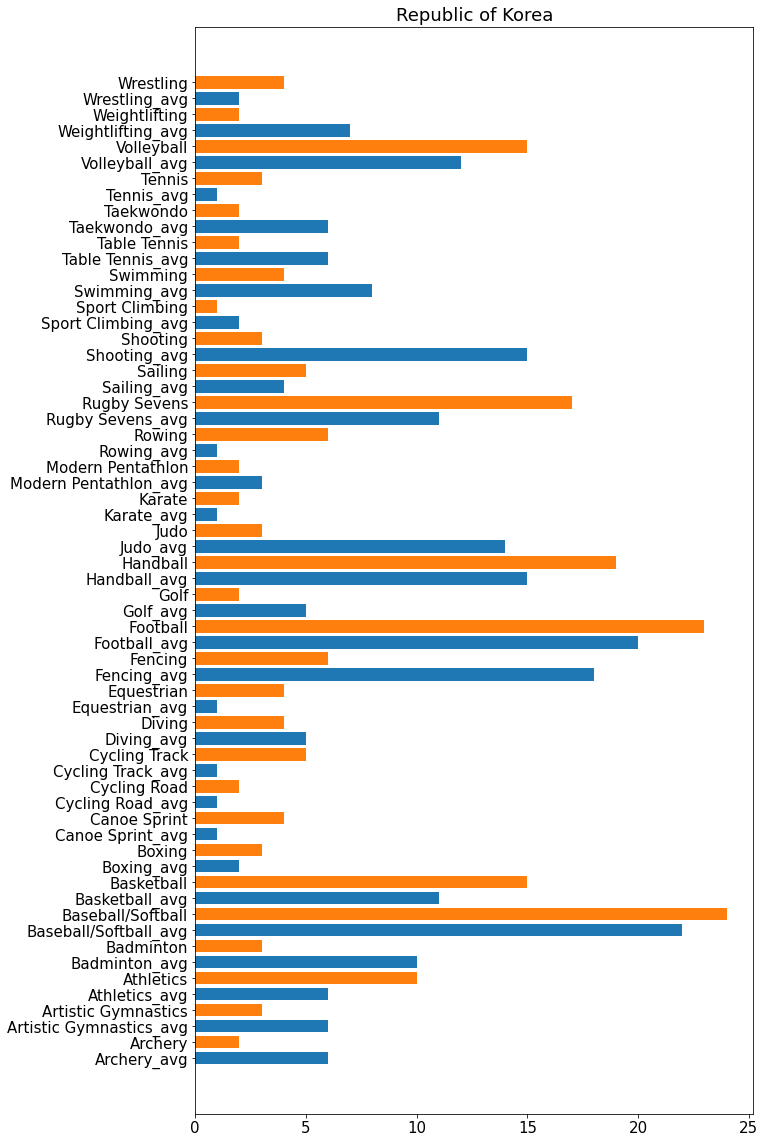

In [ ]:
  country = total_2020[total_2020['NOC']=="Republic of Korea"]
  country_sports = country.groupby('Discipline').agg('count')['NOC']
  sports_df = pd.DataFrame({'Discipline':country_sports.index, 'count':country_sports}).reset_index(drop=True)
  sports_df['mean'] = 0
  for idx, val in enumerate(sports_df['Discipline']):
    sports_df['mean'][idx] = total_sports_mean.loc[val, 'Name']

  plt.figure(figsize=(10,20))
  plt.rc('font', size=15)
  plt.barh(np.arange(0, len(sports_df['Discipline']) * 2, 2), sports_df['count'])
  plt.barh(np.arange(1, len(sports_df['mean']) * 2, 2), sports_df['mean'])
  plt.yticks(np.arange(len(sports_df['Discipline']) * 2), name_list)
  plt.title("Republic of Korea")
  plt.show()